In [1]:
import numpy as np
from os import sys, path, environ
from os import sep, mkdir, walk
from os import chdir, environ, getcwd
import os as os
import sys
import string, random
from shutil import copy, copytree
#
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.tri import Triangulation
#
import netCDF4 as nc
from ot_chaos import *
import openturns as ot
import openturns.viewer as viewer
#
colors=['#002d74', '#e85113', '#1fa12e', '#c9d200', '#f49e00', '#006ab3', '#3381ff', '#f2855a', '#54de64']

### Read the output data from netcdf, and recall distributions

In [2]:
"""
The nc file is created using the notebook called "sample_uncertain_inputs.ipync"
"""
nc_file = nc.Dataset("windio_toy/plant_energy_resource/Stochastic_atHubHeight.nc")
nc_file_var_names = [key for key in nc_file.variables.keys()] 
nc_file_var_dimensions = nc_file.variables[nc_file_var_names[1]].dimensions
nc_file_var_shape = nc_file.variables[nc_file_var_names[1]].shape
print("Variables are : ", nc_file_var_names) # get all variable names
print("Dimensions of variable 1 are : ", nc_file_var_dimensions) #get dimensions of var 1
print("Shape of variable 1 is : ", nc_file_var_shape) #get shape of var 1

#
nvar = 3
MC_sample = np.zeros((len(nc_file.variables["time"]),nvar))
MC_sample[:,0] = nc_file.variables["direction"][:]
MC_sample[:,1] = nc_file.variables["speed"][:]
MC_sample[:,2] = nc_file.variables["z0"][:]
uq_varnames = ["direction", "speed","z0"]
uq_var_marginals = ["normal", "normal", "uniform"]
#uq_var_marginals = ["kernel", "kernel", "kernel"]

Variables are :  ['time', 'direction', 'speed', 'z0', 'TI', 'ustar']
Dimensions of variable 1 are :  ('time',)
Shape of variable 1 is :  (1000,)


In [3]:
power_table  = np.genfromtxt("flow_tools_results/windio_toy/MC_hub_timeseries_power_cpstar_code_saturne.csv", delimiter=',', skip_header=1)[:,1:]
f = nc.Dataset('flow_tools_results/windio_toy/MC_hub_timeseries_velocity_code_saturne.nc')
print(f.variables.keys())

dict_keys(['vertices_x_coords', 'vertices_y_coords', 'u', 'v', 'w', 'triangle_vertices_ids'])


In [4]:
#get triangulation from netcdf    
x = f.variables['vertices_x_coords'][:]
y = f.variables['vertices_y_coords'][:]
triangles = f.variables['triangle_vertices_ids'][:]
triang = tri.Triangulation(x,y,triangles.astype(int))
#get flow variables
velocity_X = f.variables['u']
velocity_Y = f.variables['v']
velocity_Z = f.variables['w']
velocity_magnitude = np.zeros((velocity_X.shape[0],velocity_X.shape[1]))
velocity_direction = np.zeros((velocity_X.shape[0],velocity_X.shape[1]))
for j in range(velocity_X.shape[1]):
    velocity_magnitude[:,j] = np.sqrt(velocity_X[:,j]**2 + velocity_Y[:,j]**2 + velocity_Z[:,j]**2) 
    velocity_direction[:,j] = 270.-np.rad2deg(np.arctan2(velocity_Y[:,j],velocity_X[:,j]))
#
print(velocity_X.shape)
MC_sample_size = velocity_X.shape[1]

(28618, 100)


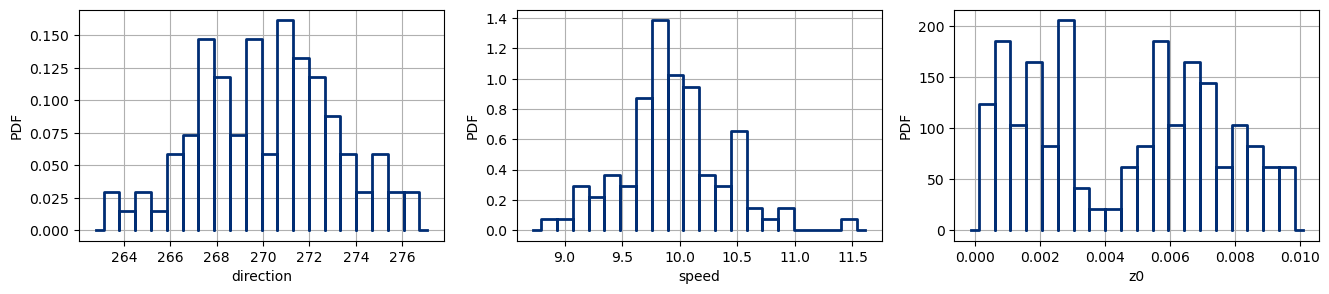

In [5]:
# plot and compare to histogram
histograms = [] 
graphs = []
for j in range(MC_sample.shape[1]):
    sample = ot.Sample([[i] for i in MC_sample[:MC_sample_size,j]])
    histograms.append(ot.HistogramFactory().buildAsHistogram(sample, 20))
    graphs.append(histograms[j].drawPDF())
    graphs[j].setColors(colors)
    graphs[j].setXTitle(uq_varnames[j])
    graphs[j].setYTitle("PDF")
    graphs[j].setLegends([""])#[uq_varnames[j]])
    graphs[j].setTitle("")
#
fig = plt.figure(figsize=(16, 3))
axs = []
for j in range(MC_sample.shape[1]):
    axs.append(fig.add_subplot(1, MC_sample.shape[1], j+1))
    _ = viewer.View(graphs[j], figure=fig, axes=[axs[j]])

### Get triang info and add a plot example

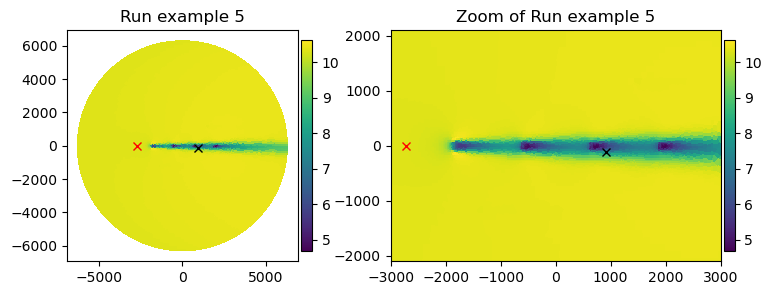

In [6]:
#get coordinates of triangle face centers
x_coords = np.zeros((velocity_X.shape[0])) 
y_coords = np.zeros((velocity_X.shape[0])) 
for j in range(velocity_X.shape[0]):
    i1, i2, i3 = triang.triangles[j]
    x_coords[j] = (triang.x[i1] + triang.x[i2] + triang.x[i3])/3.
    y_coords[j] = (triang.y[i1] + triang.y[i2] + triang.y[i3])/3.    

#Points center_line
nearest_x = [] ; nearest_ids = []
#Points little below
nearest_x_below = [] ; nearest_ids_below = []
for j in range(velocity_X.shape[0]):
    if(np.abs(y_coords[j]-0.0)<8.0):
        nearest_x.append(x_coords[j])
        nearest_ids.append(j)       
    elif(np.abs(y_coords[j]-(-120.0))<8.0):
        nearest_x_below.append(x_coords[j])
        nearest_ids_below.append(j)       
# Combine arrays into a list of tuples
combined_nearest = list(zip(nearest_x, nearest_ids))
sorted_combined_nearest = sorted(combined_nearest, key=lambda x: x[0])
sorted_nearest_x, sorted_nearest_ids = zip(*sorted_combined_nearest)
#
combined_nearest_below = list(zip(nearest_x_below, nearest_ids_below))
sorted_combined_nearest_below = sorted(combined_nearest_below, key=lambda x: x[0])
sorted_nearest_x_below, sorted_nearest_ids_below = zip(*sorted_combined_nearest_below)

        
example_point_id_1 = sorted_nearest_ids[8] ; example_point_id_2 = sorted_nearest_ids_below[220]
point_name_1 = "Upstream point" ; point_name_2 = "Downstream point in wake"
MC_example = 5
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].set_title('Run example ' + str(MC_example))
ax[0].set_aspect('equal')
cntr = ax[0].tripcolor(triang,velocity_magnitude[:,MC_example])#, vmin=-2,vmax=4)
fig.colorbar(cntr, ax=ax[0],fraction=0.03, pad=0.01)
ax[0].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
ax[0].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
#
ax[1].set_title('Zoom of Run example ' + str(MC_example))
ax[1].set_aspect('equal')
cntr = ax[1].tripcolor(triang,velocity_magnitude[:,MC_example])#, vmin=-2,vmax=4)
fig.colorbar(cntr, ax=ax[1],fraction=0.03, pad=0.01)
ax[1].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
ax[1].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
ax[1].set_xlim(-3000,3000) ; ax[1].set_ylim(-2100,2100)
plt.show()
fig.savefig('test.jpg',dpi=300,bbox_inches='tight')
plt.close()

### Example of distribution at above marked (red and black crosses) spatial points

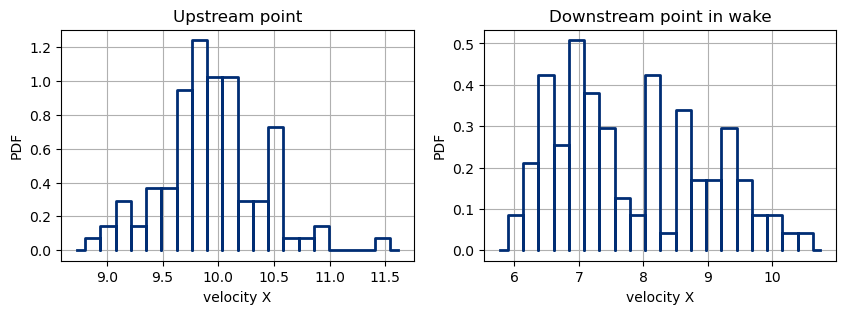

In [7]:
velocity_X_sample_at_point1  = ot.Sample([[i] for i in velocity_X[example_point_id_1,:]])
velocity_X_sample_at_point2  = ot.Sample([[i] for i in velocity_X[example_point_id_2,:]])
# plot and compare to histogram
histogram_point1 = ot.HistogramFactory().buildAsHistogram(velocity_X_sample_at_point1, 20)
graph_point1 = histogram_point1.drawPDF()
graph_point1.setColors(colors)
graph_point1.setXTitle("velocity X")
graph_point1.setYTitle("PDF")
graph_point1.setTitle("")
graph_point1.setLegends([""])
#
histogram_point2 = ot.HistogramFactory().buildAsHistogram(velocity_X_sample_at_point2, 20)
graph_point2 = histogram_point2.drawPDF()
graph_point2.setColors(colors)
graph_point2.setXTitle("velocity X")
graph_point2.setYTitle("PDF")
graph_point2.setTitle("")
graph_point2.setLegends([""])

fig = plt.figure(figsize=(10, 3))
ax_1 = fig.add_subplot(1, 2, 1)
ax_1.set_title(point_name_1)
_ = viewer.View(graph_point1, figure=fig, axes=[ax_1])
ax_2 = fig.add_subplot(1, 2, 2)
ax_2.set_title(point_name_2)
_ = viewer.View(graph_point2, figure=fig, axes=[ax_2])

plt.show()

### Simple statistics as the mean and variance

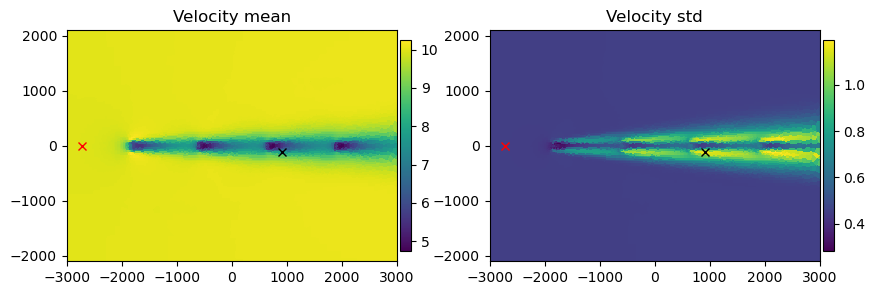

Upstream point mean is 9.964234914779663 and std is 0.44735985399067824
Downstream point in wake mean is 7.835976343154908 and std is 1.1664737980305353


In [8]:
variable_to_test = velocity_magnitude
sample_mean = np.mean(variable_to_test,axis=1)
sample_std = np.std(variable_to_test,axis=1)
##        
fig,ax = plt.subplots(1,2,figsize=(10,3))
ax[0].set_aspect('equal')
cntr = ax[0].tripcolor(triang,sample_mean)#, vmin=-2.0,vmax=2.0)
fig.colorbar(cntr, ax=ax[0],fraction=0.03, pad=0.01)
ax[0].set_title('Velocity mean')
ax[0].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
ax[0].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
ax[0].set_xlim(-3000,3000) ; ax[0].set_ylim(-2100,2100)
##
ax[1].set_aspect('equal')
cntr = ax[1].tripcolor(triang,sample_std, vmin=np.min(sample_std),vmax=np.max(sample_std))
fig.colorbar(cntr, ax=ax[1],fraction=0.03, pad=0.01)
ax[1].set_xlim(-3000,3000) ; ax[1].set_ylim(-2100,2100)
ax[1].set_title('Velocity std')
ax[1].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
ax[1].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
plt.show()

print(point_name_1 + " mean is "+str(sample_mean[example_point_id_1])+ " and std is " + str(sample_std[example_point_id_1]))
print(point_name_2 + " mean is "+str(sample_mean[example_point_id_2])+ " and std is " + str(sample_std[example_point_id_2]))

### Sobol Indices

Add to overleaf.

The variance of a model $Y= \sum_{\mathcal{I} \subseteq \{1, ..., V \}} \mathcal{M}_\mathcal{I}(\theta_\mathcal{I})$ can be written as : 
$
    \begin{matrix}
    \mathbb{V}[Y] & = & cov~(Y,Y) \\
    & = & cov~\left( \sum_{\mathcal{I} \subseteq \{1, ..., V \}} \mathcal{M}_\mathcal{I}(\theta_\mathcal{I}), \sum_{\mathcal{J} \subseteq \{1, ..., V \}} \mathcal{M}_\mathcal{J}(\theta_\mathcal{J})\right) \\
    & = & \sum_{\mathcal{I} \subseteq \{1, ..., V \}} \sum_{\mathcal{J} \subseteq \{1, ..., V \}} cov~\left( \mathcal{M}_\mathcal{I}(\theta_\mathcal{I}), \mathcal{M}_\mathcal{J}(\theta_\mathcal{J})\right) \\
    & = &  \sum_{\mathcal{I} \subseteq \{1, ..., V \}} \left( \mathbb{V}\left[\mathcal{M}_\mathcal{I}(\theta_\mathcal{I})\right] + \sum_{\mathcal{J} \ne \mathcal{I} \subseteq \{1, ..., V \}} cov~\left( \mathcal{M}_\mathcal{I}(\theta_\mathcal{I}), \mathcal{M}_\mathcal{J}(\theta_\mathcal{J})\right) \right)
    \end{matrix} \ .
$

This is called the ANCOVA decomposition.

 A normalization of the output's variance results with the following general contribution indices:
$
    \begin{matrix}
    S_{\mathcal{I}}^{(cov)} & = & S_{\mathcal{I}}^{(U)} + S_{\mathcal{I}}^{(C)} \\
    & & \\
    & = & \dfrac{\mathbb{V}\left[\mathcal{M}_\mathcal{I}(\theta_\mathcal{I})\right]}{\mathbb{V}\left[Y\right]}  + \dfrac{\sum_{\mathcal{J} \ne \mathcal{I} \subseteq \{1, ..., V \}} cov~\left( \mathcal{M}_\mathcal{I}(\theta_\mathcal{I}), \mathcal{M}_\mathcal{I}(\theta_\mathcal{J}) \right)}{\mathbb{V}\left[Y\right]} \ ,
    \end{matrix}
$

where $S_{\mathcal{I}}^{(cov)}$ is called the covariance-based sensitivity index of variables $\boldsymbol{\Theta}_{\mathcal{I}}$, representing both their uncorrelated contributions, denoted $S_{\mathcal{I}}^{(U)}$, and their correlative contributions, denoted $S_{\mathcal{I}}^{(C)}$, to the output's variance.

In the case of independent input variables $\boldsymbol{\Theta}$, the covariance terms in the ANCOVA decomposition vanish. This gives the so called ANOVA decomposition. The correlative indices $S_{\mathcal{I}}^{(C)}$ also consequently vanish, and the covariance-based sensitivity index $S_{\mathcal{I}}^{(cov)}=S_{\mathcal{I}}^{(U)}$ is no other than the so called Sobol' index denoted $S_{\mathcal{I}}$.


Adding Sobol' indices of all different contribution subsets $\mathcal{I} \subseteq \{1, ..., V \}$ equals 1. This means that they allow to rank each subset, in terms of relative variance contribution, to the output $Y$. The contributions can be either analyzed for each subset independently, or used to compute the contribution of a given variable $\Theta_i$. Indeed, the share of subset $\mathcal{I}=\{i\}$ allows to compute the \textit{$1^{st}$ order contribution} of $\Theta_i$ (\textit{$1^{st}$ Sobol' index}, denoted $S_i$), while adding the shares of all subsets that satisfy $i \in \mathcal{I}$ quantifies the \textit{total contribution} of the variable including its interactions (\textit{total Sobol' index}, denoted $S_i^T$). Formally, the first Sobol' index can be written as in Equation:

$
    S_i = \frac{\mathbb{V}(\mathbb{E}[Y|\boldsymbol{\Theta_i}])}{\mathbb{V}[Y])} \ ,
$

where $\mathbb{E}[Y|\boldsymbol{\Theta_i}]$ is the expectation of model values where only $\Theta_i$ is varied, and $\mathbb{V}(\mathbb{E}[Y|\boldsymbol{\Theta_i}])$ is called \textit{partial variance}. Similarly, interaction indices, as the \textit{second order sensitivity index} defining the joint influence of parameters $\Theta_i$ and $\Theta_j$, is defined in Equation:

$
    S_{ij} = \frac{\mathbb{V}(\mathbb{E}[Y|\boldsymbol{\Theta_i},\boldsymbol{\Theta_j}])}{\mathbb{V}[Y])} \ .
$

Lastly, total index is written  in Equation:

$
    S_{i}^T = S_i + \sum_{j \neq i} S_{ij} +  \sum_{j \neq i, k \neq i, j<k} S_{ijk} + \dots = 1 - \sum_{\mathcal{I}\subseteq \{1, ..., V \}, i \not\in \mathcal{I} } S_{I} \ .
$


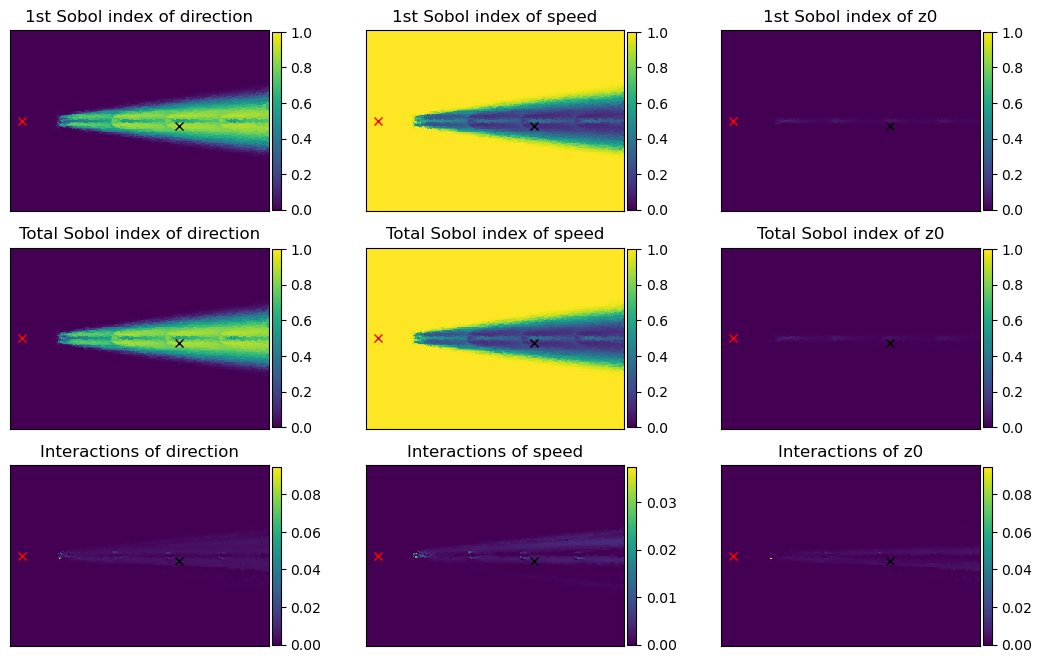

In [18]:
sobol_indices = np.zeros((velocity_X.shape[0],nvar))
total_sobol_indices = np.zeros((velocity_X.shape[0],nvar))
input_variable_array = MC_sample[:MC_sample_size,:]

#Show the polynomial terms
#Fitting metrics #show leave_one_out scores
recompute_sobols = False
if(recompute_sobols):
    copula_type = "independent"  #choices: gaussian, independent
    max_PC_deg = 3
    npoints = velocity_X.shape[0]
    for i in range(npoints):
        print('Point '+str(i+1)+'/'+str(npoints), end='\r')
        if(sample_std[i]!=0):        
            fullSet = StatisticalSet(input_variable_array[:,:],velocity_X[i,:])
            training_size = fullSet.setSize
            test_size = 0
            otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                    test_size=test_size, prediction_size=0, number_of_sets=1)
            otChaosObject.marginals = uq_var_marginals

            for v in range(fullSet.inputDimension):
                otChaosObject.marginals.append(uq_var_marginals[v])
                otChaosObject.copula = copula_type

            otChaosObject.polynomialDegree = max_PC_deg
            otChaosObject.construct_PCE_ot()
            chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
            for v in range(fullSet.inputDimension):
                sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)
else:
    f = nc.Dataset('flow_tools_results/windio_toy/SA_hub_timeseries_velocity_magnitude_code_saturne.nc')
    for j in range(nvar):
        sobol_indices[:,j] = f.variables[uq_varnames[j]+'_sobol_index_1st'][:]
        total_sobol_indices[:,j] = f.variables[uq_varnames[j]+'_sobol_index_total'][:]
        
fig,ax = plt.subplots(3,nvar,figsize=(13,8))
#
for j in range(nvar):
    ax[0,j].set_aspect('equal')
    cntr = ax[0,j].tripcolor(triang,sobol_indices[:,j], vmin=0.0,vmax=1.0)
    fig.colorbar(cntr, ax=ax[0,j],fraction=0.03, pad=0.01)
    ax[0,j].set_title('1st Sobol index of '+uq_varnames[j])
    ax[0,j].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
    ax[0,j].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
    ax[0,j].set_xlim(-3000,3000) ; ax[0,j].set_ylim(-2100,2100)
    ax[0,j].tick_params(axis='x', which='both', bottom=False,top=False,labelbottom=False)
    ax[0,j].tick_params(axis='y', which='both', left=False,right=False,labelleft=False)
    #
    ax[1,j].set_aspect('equal')
    cntr = ax[1,j].tripcolor(triang,total_sobol_indices[:,j], vmin=0.0,vmax=1.0)
    fig.colorbar(cntr, ax=ax[1,j],fraction=0.03, pad=0.01)
    ax[1,j].set_title('Total Sobol index of '+uq_varnames[j])
    ax[1,j].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
    ax[1,j].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
    ax[1,j].set_xlim(-3000,3000) ; ax[1,j].set_ylim(-2100,2100)
    ax[1,j].tick_params(axis='x', which='both', bottom=False,top=False,labelbottom=False)
    ax[1,j].tick_params(axis='y', which='both', left=False,right=False,labelleft=False)
    #
    ax[2,j].set_aspect('equal')
    cntr = ax[2,j].tripcolor(triang,total_sobol_indices[:,j]-sobol_indices[:,j])
    fig.colorbar(cntr, ax=ax[2,j],fraction=0.03, pad=0.01)
    ax[2,j].set_title('Interactions of '+uq_varnames[j])
    ax[2,j].plot(x_coords[example_point_id_1],y_coords[example_point_id_1], linestyle=None, marker="x",color="red")
    ax[2,j].plot(x_coords[example_point_id_2],y_coords[example_point_id_2], linestyle=None, marker="x",color="black")
    ax[2,j].set_xlim(-3000,3000) ; ax[2,j].set_ylim(-2100,2100)
    ax[2,j].tick_params(axis='x', which='both', bottom=False,top=False,labelbottom=False)
    ax[2,j].tick_params(axis='y', which='both', left=False,right=False,labelleft=False)

plt.show()
#fig.savefig('Velocity_X_1stSobol_uref.jpg',dpi=300,bbox_inches='tight')

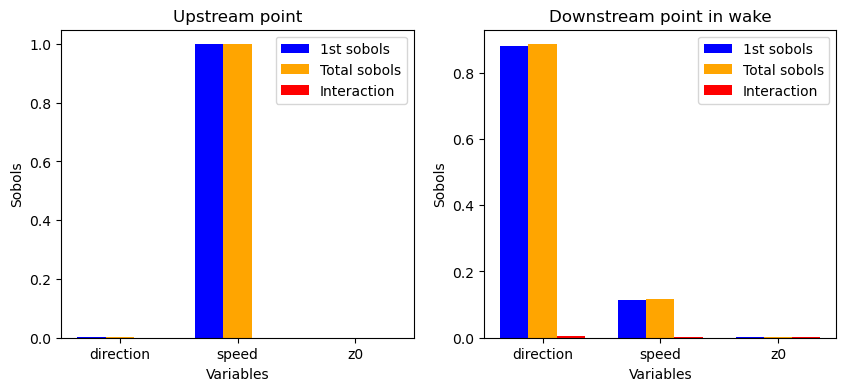

In [19]:
# Set up the figure and axes

fig,ax = plt.subplots(1,2,figsize=(10,4))
# Bar positions
bar_width=0.24
items = uq_varnames
bar_positions1 = np.arange(len(items))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width
#
values1 = [sobol_indices[example_point_id_1,0],sobol_indices[example_point_id_1,1],sobol_indices[example_point_id_1,2]]
values2 = [total_sobol_indices[example_point_id_1,0],total_sobol_indices[example_point_id_1,1],total_sobol_indices[example_point_id_1,2]]
values3 = [total_sobol_indices[example_point_id_1,0]-sobol_indices[example_point_id_1,0], total_sobol_indices[example_point_id_1,1]-sobol_indices[example_point_id_1,1], total_sobol_indices[example_point_id_1,2]-sobol_indices[example_point_id_1,2]]
# Create bar plots
ax[0].bar(bar_positions1, values1, width=bar_width, label='1st sobols', color='blue')
ax[0].bar(bar_positions2, values2, width=bar_width, label='Total sobols', color='orange')
ax[0].bar(bar_positions3, values3, width=bar_width, label='Interaction', color='red')

# Set labels and title
ax[0].set_xlabel('Variables')
ax[0].set_ylabel('Sobols')
# Set x-axis ticks and labels
ax[0].set_xticks(bar_positions2)
ax[0].set_xticklabels(items)
ax[0].set_title(point_name_1)
ax[0].legend()
#
values1 = [sobol_indices[example_point_id_2,0],sobol_indices[example_point_id_2,1],sobol_indices[example_point_id_2,2]]
values2 = [total_sobol_indices[example_point_id_2,0],total_sobol_indices[example_point_id_2,1],total_sobol_indices[example_point_id_2,2]]
values3 = [total_sobol_indices[example_point_id_2,0]-sobol_indices[example_point_id_2,0], total_sobol_indices[example_point_id_2,1]-sobol_indices[example_point_id_2,1], total_sobol_indices[example_point_id_2,2]-sobol_indices[example_point_id_2,2]]
# Create bar plots
ax[1].bar(bar_positions1, values1, width=bar_width, label='1st sobols', color='blue')
ax[1].bar(bar_positions2, values2, width=bar_width, label='Total sobols', color='orange')
ax[1].bar(bar_positions3, values3, width=bar_width, label='Interaction', color='red')

# Set labels and title
ax[1].set_xlabel('Variables')
ax[1].set_ylabel('Sobols')
# Set x-axis ticks and labels
ax[1].set_xticks(bar_positions2)
ax[1].set_xticklabels(items)
ax[1].set_title(point_name_2)
ax[1].legend()
#
# Show the plot
plt.show()

In [20]:
write_sobols_in_nc = False
if(recompute_sobols and write_sobols_in_nc):
    nc_file_name = "flow_tools_results/windio_toy/SA_hub_timeseries_velocity_Y_code_saturne.nc"
    ds = nc.Dataset(nc_file_name, 'w', format='NETCDF4')

    #Declare dimensions
    spatial_points = ds.createDimension('spatial_points', velocity_X.shape[0])

    #Declare variables
    sobol_index_1st_list = []
    sobol_index_total_list = []
    for j in range(nvar):
        #declare
        sobol_index_1st_list.append(ds.createVariable(uq_varnames[j]+'_sobol_index_1st', 'f4', ('spatial_points')))
        sobol_index_1st_list[j].units = ''
        sobol_index_total_list.append(ds.createVariable(uq_varnames[j]+'_sobol_index_total', 'f4', ('spatial_points')))
        sobol_index_total_list[j].units = ''
        #fill
        sobol_index_1st_list[j][:] = sobol_indices[:,j]
        sobol_index_total_list[j][:] = total_sobol_indices[:,j]

    ds.close()

### Power post-processing

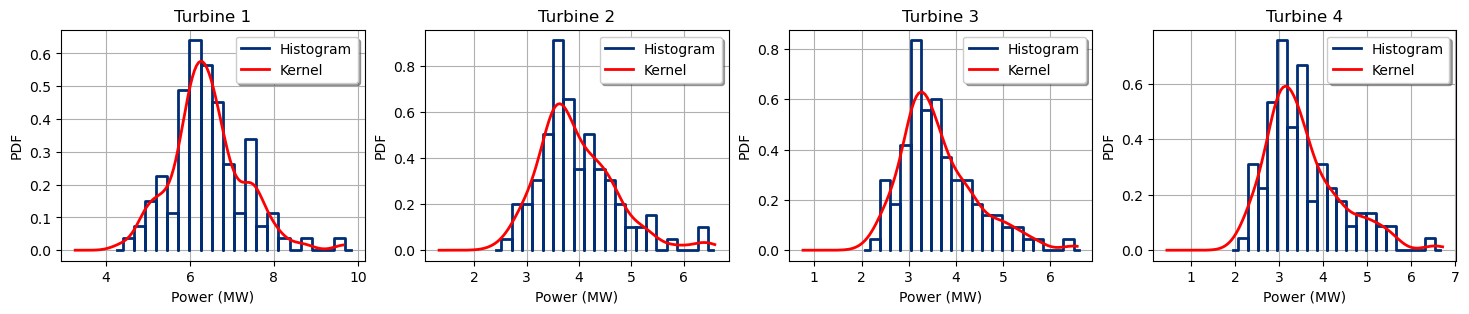

In [21]:
# read data
number_of_turbines = power_table.shape[1]

power_histograms = []
power_KDE = []
power_graphs = []
kernel = ot.KernelSmoothing(ot.Normal())
for j in range(number_of_turbines):
    power_sample = ot.Sample([[i/10**6] for i in power_table[:,j]])
    # plot and compare to histogram
    power_histograms.append(ot.HistogramFactory().buildAsHistogram(power_sample, 20))
    power_graphs.append(power_histograms[j].drawPDF())
    power_graphs[j].setColors(colors)
    power_graphs[j].setXTitle("Power (MW)")
    power_graphs[j].setYTitle("PDF")
    power_graphs[j].setTitle("")
    
    
    power_KDE.append(kernel.build(power_sample))
    power_graphs[j].add(power_KDE[j].drawPDF())
    
    power_graphs[j].setLegends(["Histogram", "Kernel"])

fig = plt.figure(figsize=(18, 3))
axs = []
for j in range(number_of_turbines):
    axs.append(fig.add_subplot(1, number_of_turbines, j+1))
    axs[j].set_title("Turbine "+str(j+1))
    _ = viewer.View(power_graphs[j], figure=fig, axes=[axs[j]])
plt.show()

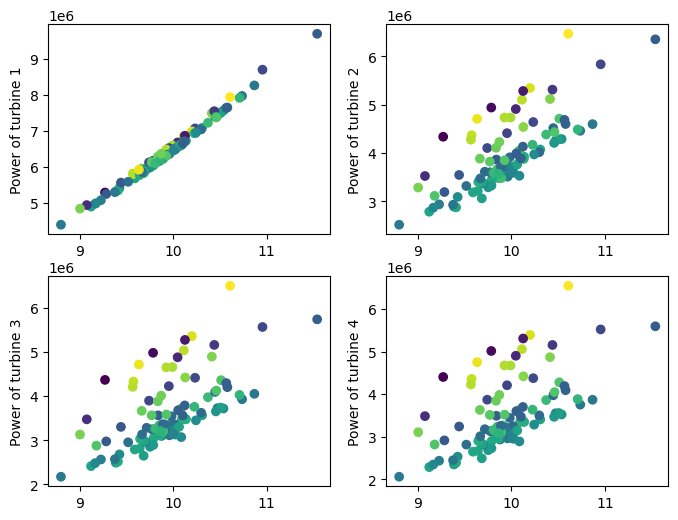

In [22]:
fig,ax = plt.subplots(2,2,figsize=(8,6))

MC_direction = MC_sample[:MC_sample_size,0]
MC_speed = MC_sample[:MC_sample_size,1]
MC_z0 = MC_sample[:MC_sample_size,2]

dependency_var = MC_speed
color_var = MC_direction
ax[0,0].scatter(dependency_var, power_table[:,0], c=color_var, label='test')
ax[0,0].set_ylabel('Power of turbine 1')
ax[0,1].scatter(dependency_var, power_table[:,1], c=color_var)
ax[0,1].set_ylabel('Power of turbine 2')
ax[1,0].scatter(dependency_var, power_table[:,2], c=color_var)
ax[1,0].set_ylabel('Power of turbine 3')
ax[1,1].scatter(dependency_var, power_table[:,3], c=color_var)
ax[1,1].set_ylabel('Power of turbine 4')
plt.show()

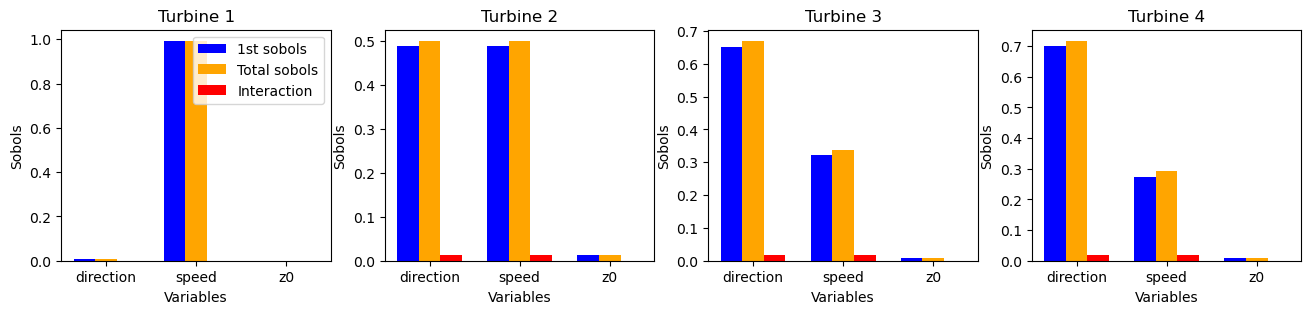

In [24]:
power_sobol_indices = np.zeros((power_table.shape[1],nvar))
power_total_sobol_indices = np.zeros((power_table.shape[1],nvar))

compute_power_sobols = True
#Show polynomials
if(compute_power_sobols):
    copula_type = "independent"  #choices: gaussian, independent
    PC_deg = 3
    for i in range(number_of_turbines):
        if(sample_std[i]!=0):        
            fullSet = StatisticalSet(input_variable_array[:,:],power_table[:,i])
            training_size = fullSet.setSize
            test_size = 0
            otChaosObject = OTChaos(fullSet, training_size=training_size, \
                                    test_size=test_size, prediction_size=0, number_of_sets=1)
            otChaosObject.marginals = []

            for v in range(fullSet.inputDimension):
                otChaosObject.marginals.append(uq_var_marginals[v])
                otChaosObject.copula = copula_type

            otChaosObject.polynomialDegree= PC_deg
            otChaosObject.construct_PCE_ot()
            chaosSI = ot.FunctionalChaosSobolIndices(otChaosObject.polynomialChaosResult) 
            for v in range(fullSet.inputDimension):
                power_sobol_indices[i,v] =  chaosSI.getSobolIndex(v)  
                power_total_sobol_indices[i,v] =  chaosSI.getSobolTotalIndex(v)  
                

fig,ax = plt.subplots(1,number_of_turbines,figsize=(16,3))
# Bar positions
bar_width=0.24
items = uq_varnames
bar_positions1 = np.arange(len(items))
bar_positions2 = bar_positions1 + bar_width
bar_positions3 = bar_positions2 + bar_width

for i in range(number_of_turbines):
    values1 = [] ; values2 = [] ; values3 = []
    for j in range(nvar):      
        values1.append(power_sobol_indices[i,j])
        values2.append(power_total_sobol_indices[i,j])
        values3.append(power_total_sobol_indices[i,j]-power_sobol_indices[i,j])
    # Create bar plots
    ax[i].bar(bar_positions1, values1, width=bar_width, label='1st sobols', color='blue')
    ax[i].bar(bar_positions2, values2, width=bar_width, label='Total sobols', color='orange')
    ax[i].bar(bar_positions3, values3, width=bar_width, label='Interaction', color='red')

    # Set labels and title
    ax[i].set_xlabel('Variables')
    ax[i].set_ylabel('Sobols')
    # Set x-axis ticks and labels
    ax[i].set_xticks(bar_positions2)
    ax[i].set_xticklabels(items)
    ax[i].set_title("Turbine " + str(i+1))
    if(i==0):
        ax[i].legend(loc="best")
    
# Show the plot
plt.show()